# LDDMM: compute velocity and reconstruct parametrization

In [1]:
import shutil
from pathlib import Path

import numpy as np
import pyvista as pv

import polpo.lddmm as plddmm
import polpo.preprocessing.dict as ppdict
from polpo.plot.pyvista import RegisteredMeshesGifPlotter
from polpo.preprocessing.load.pregnancy.jacobs import MeshLoader
from polpo.preprocessing.mesh.io import DictMeshWriter
from polpo.preprocessing.mesh.registration import RigidAlignment

W0929 12:26:23.202000 180940 site-packages/torch/utils/cpp_extension.py:118] No CUDA runtime is found, using CUDA_HOME='/usr'


In [2]:
RECOMPUTE = True  # in case registration has already been run
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

In [3]:
OUTPUTS_DIR = Path("results") / "velocity_example"

if OUTPUTS_DIR.exists() and RECOMPUTE:
    shutil.rmtree(OUTPUTS_DIR)

## Loading meshes

In [4]:
struct_subset = ["L_Hipp"]


path2mesh_01 = MeshLoader(
    subject_subset=["01"],
    session_subset=[1, 26],
    struct_subset=["L_Hipp"],
    as_mesh=True,
)

dict_to_vals = ppdict.ExtractUniqueKey(nested=True)


raw_meshes = (path2mesh_01 + dict_to_vals)()

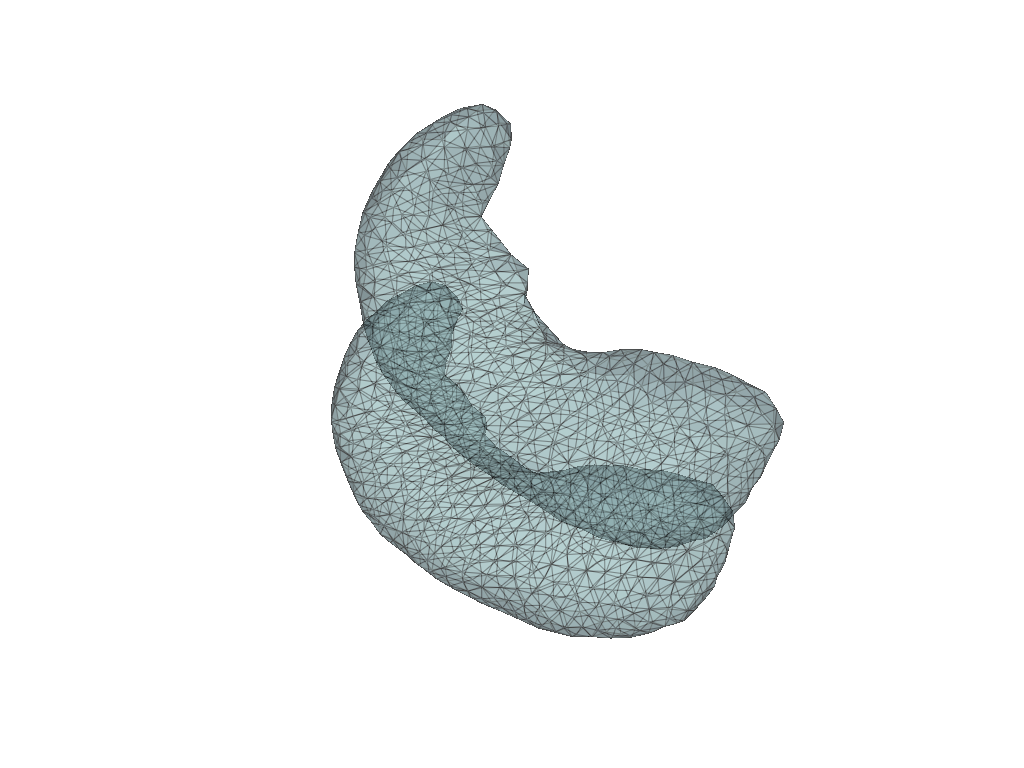

In [5]:
pl = pv.Plotter(border=False)

for mesh in raw_meshes.values():
    pl.add_mesh(mesh, show_edges=True, opacity=0.5)

pl.show()

In [6]:
prep_pipe = RigidAlignment(max_iterations=500)

meshes = prep_pipe(raw_meshes)

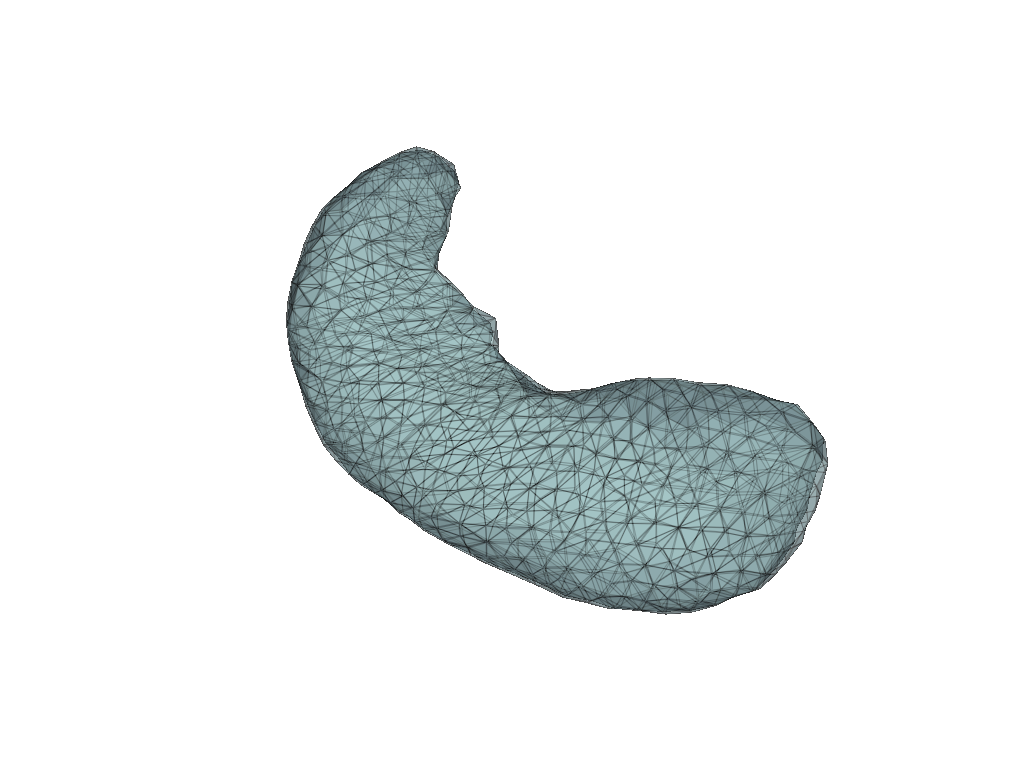

In [7]:
pl = pv.Plotter(border=False)

for mesh in meshes.values():
    pl.add_mesh(mesh, show_edges=True, opacity=0.5)

pl.show()

## Registration

Closely following [LDDMM: how to register a mesh to a template?](./lddmm_register_mesh_template.ipynb), we register A to B and C to B.

In [8]:
meshes_writer = DictMeshWriter(dirname=OUTPUTS_DIR, ext="vtk")

# index: path
dataset = meshes_writer({index: mesh for index, mesh in meshes.items()})

In [9]:
kernel_width = 10.0
registration_kwargs = dict(
    kernel_width=kernel_width,
    regularisation=1.0,
    max_iter=2000,
    freeze_control_points=False,
    metric="varifold",
    tol=1e-16,
    attachment_kernel_width=2.0,
)

registration_dir = OUTPUTS_DIR / "registration"

source, target = meshes.keys()

if not registration_dir.exists():
    plddmm.registration.estimate_registration(
        source=dataset[source],
        target=dataset[target],
        output_dir=registration_dir,
        **registration_kwargs,
    )

Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 10.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 10
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/velocity_example/registration/deformetrica-state.p.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
instantiating kernel torch with kernel_width 10.0 and gpu_mode GpuMode.KERNEL. addr: 0x7f80409b5be0
instantiating kernel torch with kernel_width 2.0 and gpu_mode GpuMode.KERNEL. addr: 0x7f80409d2b40
>> Set of 24 control points defined.
>> Momenta initialized to zero, for 1 subjects.
dtype=float32
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

------------------------------------- Iteration: 1 -------------------------------------

---

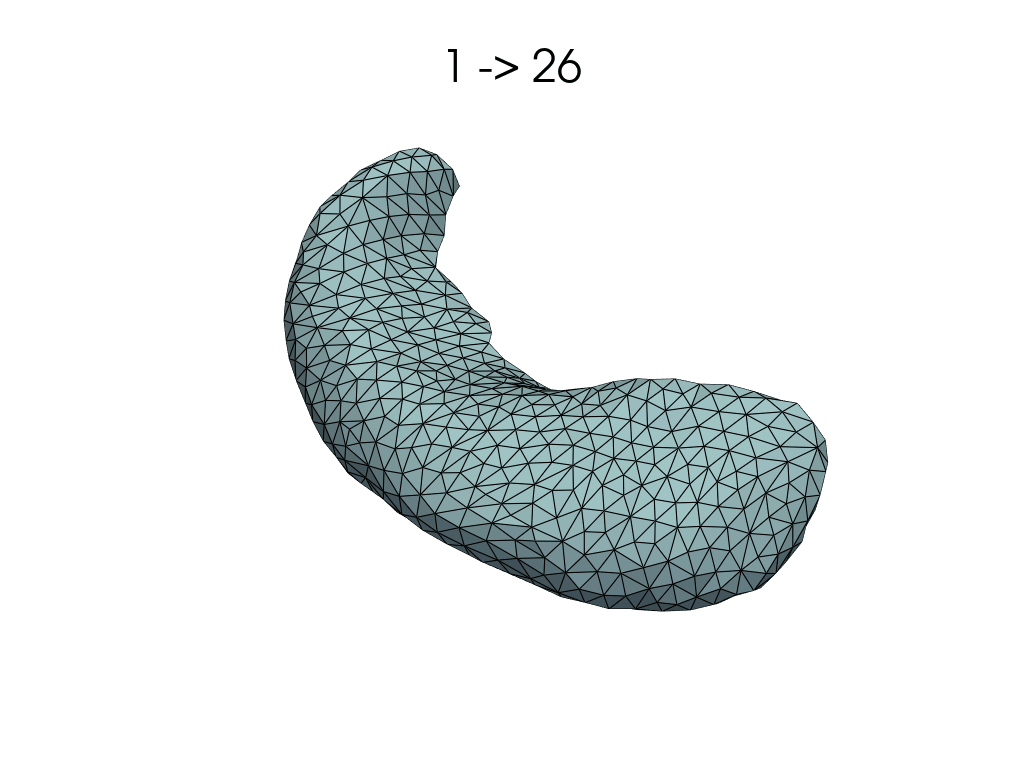

In [10]:
flow_meshes = plddmm.io.load_deterministic_atlas_flow(
    registration_dir,
    as_pv=True,
)

pl = RegisteredMeshesGifPlotter()
pl.add_title(f"{source} -> {target}")

pl.add_meshes(flow_meshes)
pl.close()

pl.show()

## Compute velocity and reconstruct parametrization

Given control points and momenta, we start by computing the velocity at control points (NB: any other choice of `x` could have been done).

In [11]:
cp = plddmm.io.load_cp(registration_dir, as_path=False)
momenta = plddmm.io.load_momenta(registration_dir, as_path=False)

vel = plddmm.geometry.velocity_at_x(cp, cp, momenta, kernel_width=kernel_width)

We now do the inverse operation: given the velocity and control points, we compute the momenta.

In [12]:
momenta_ = plddmm.geometry.reconstruct_parametrization(
    vel, cp, kernel_width=kernel_width
)

/home/luisfpereira/Repos/github/polpo/polpo/lddmm/geometry.py:358: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1765.)
  cholesky_kernel_matrix = torch.cholesky(kernel_matrix)


In [13]:
np.amax(np.abs(momenta - momenta_))

np.float64(8.041399688826778e-05)